In [4]:
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.metrics import accuracy_score

# Проверка доступности GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [5]:
import matplotlib.pyplot as plt
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




# Функция для построения графиков потерь и точности
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy During Training')
    plt.legend()
    
    plt.show()


# Построение матрицы ошибок
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()




# Функция для подсчета количества изображений в каждом классе
def plot_class_distribution(dataset, dataset_name):
    # Получаем имена классов
    class_names = dataset.classes

    # Считаем количество изображений в каждом классе
    class_counts = Counter([class_names[class_idx] for _, class_idx in dataset.imgs])

    # Извлекаем данные для графика
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    # Строим график
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xticks(rotation=45)
    plt.show()






Train dataset size: 68518
Val dataset size: 7611
Classes: ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised']


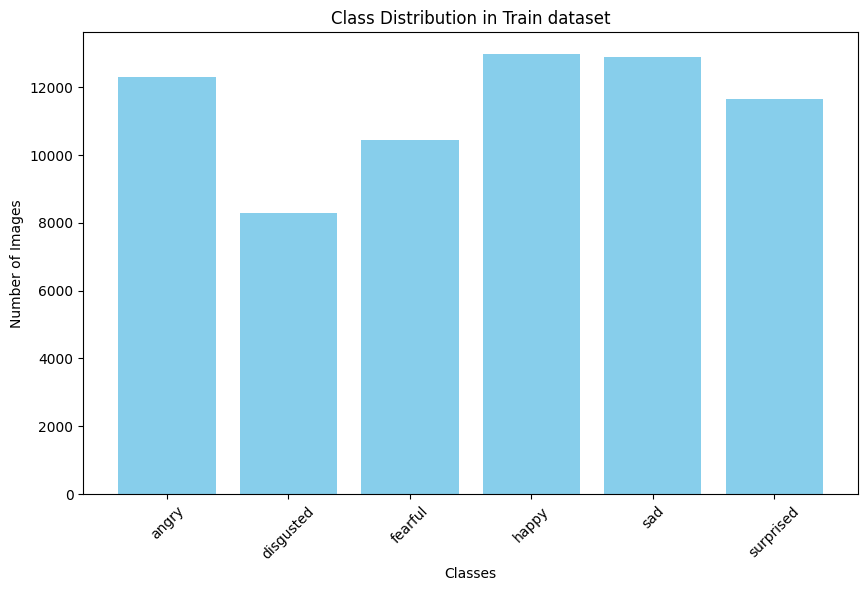

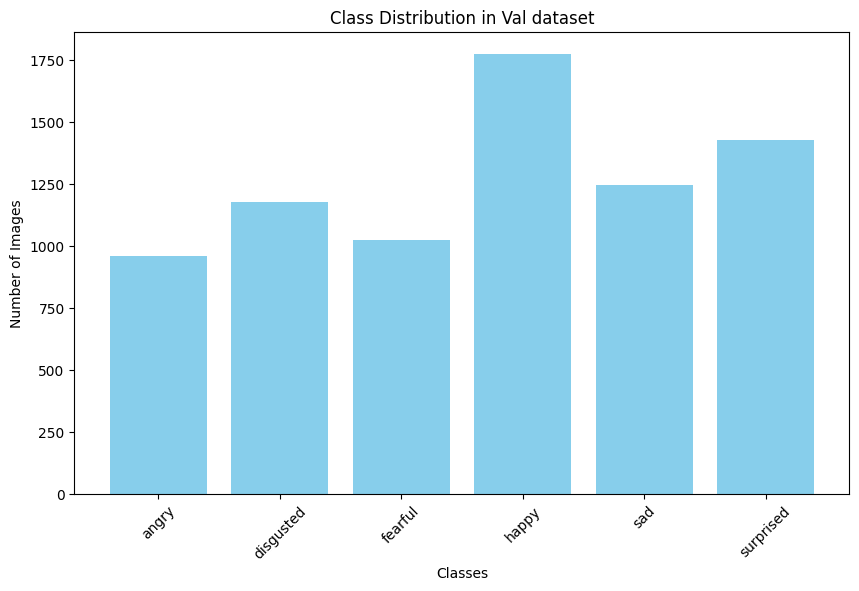

In [6]:
# Задаем размер входного изображения
input_size = 48  

# Трансформации для тренировочного набора данных 
data_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Трансформации для валидации 
val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Загрузка данных из разных папок
train_dir = r"C:\Users\Omen\Desktop\Datasets_NEW\train"  # Папка с тренировочными данными
val_dir = r"C:\Users\Omen\Desktop\Datasets_NEW\test"  # Папка с валидационными данными

# Создаем наборы данных с использованием трансформаций
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# DataLoader для загрузки данных в батчах
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Словарь для DataLoader'ов и размеров наборов данных
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes  # Можно использовать только тренировочные классы, если они одинаковы

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Classes: {class_names}")

plot_class_distribution(train_dataset, 'Train dataset')
plot_class_distribution(val_dataset, 'Val dataset')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionCNN, self).__init__()

        self.features = nn.Sequential(
            # Первый блок сверток
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 3 канала для цветных изображений
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Уменьшение размерности

            # Второй блок сверток
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Уменьшение размерности

            # Третий блок сверток
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Уменьшение размерности
        )

        # Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 1024),  # Входной размер: 256 каналов после сверток
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)  # Выходной слой с числом классов
        )

    def forward(self, x):
        x = self.features(x)  # Применение сверток
        x = x.view(x.size(0), -1)  # Разворачиваем тензор для подачи в fully connected слои
        x = self.classifier(x)  # Применение классификатора
        return x




# Инициализируем модель
num_classes = len(class_names)
model = EmotionRecognitionCNN(num_classes=num_classes)
model = model.to(device)

# Определим функцию потерь и оптимизатор с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Добавляем L2-регуляризацию через weight_decay

# Планировщик для уменьшения скорости обучения при остановке улучшений
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
# Реализация ранней остановки
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = float('inf')

    def __call__(self, val_loss, model, model_save_path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_save_path):
        '''Сохранение модели, если валидационная ошибка уменьшилась'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_save_path)
        self.best_loss = val_loss


In [8]:
import time
import torch
from tqdm import tqdm
import time

def train_model_with_metrics(model, criterion, optimizer, scheduler, num_epochs=25, model_save_path='best_model.pth', patience=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Списки для записи метрик
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            dataloader = dataloaders[phase]
            dataset_size = dataset_sizes[phase]

            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Progress", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                early_stopping(epoch_loss, model, model_save_path)
                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    time_elapsed = time.time() - since
                    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                    model.load_state_dict(torch.load(model_save_path))
                    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
                    return model

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    model.load_state_dict(torch.load(model_save_path))

    # Построим графики метрик
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    return model


Epoch 1/20
----------


train Loss: 1.5414 Acc: 0.3677


val Loss: 1.2458 Acc: 0.5323
Validation loss decreased (inf --> 1.245798).  Saving model ...
Epoch 2/20
----------


train Loss: 1.2380 Acc: 0.5174


val Loss: 1.1332 Acc: 0.5805
Validation loss decreased (1.245798 --> 1.133211).  Saving model ...
Epoch 3/20
----------


train Loss: 1.1074 Acc: 0.5756


val Loss: 1.0127 Acc: 0.6266
Validation loss decreased (1.133211 --> 1.012651).  Saving model ...
Epoch 4/20
----------


train Loss: 1.0173 Acc: 0.6112


val Loss: 0.9067 Acc: 0.6707
Validation loss decreased (1.012651 --> 0.906693).  Saving model ...
Epoch 5/20
----------


train Loss: 0.9426 Acc: 0.6428


val Loss: 0.9078 Acc: 0.6806
EarlyStopping counter: 1 out of 5
Epoch 6/20
----------


train Loss: 0.8735 Acc: 0.6702


val Loss: 0.8173 Acc: 0.7176
Validation loss decreased (0.906693 --> 0.817250).  Saving model ...
Epoch 7/20
----------


train Loss: 0.8033 Acc: 0.6973


val Loss: 0.7466 Acc: 0.7534
Validation loss decreased (0.817250 --> 0.746619).  Saving model ...
Epoch 8/20
----------


train Loss: 0.7346 Acc: 0.7253


val Loss: 0.6966 Acc: 0.7797
Validation loss decreased (0.746619 --> 0.696569).  Saving model ...
Epoch 9/20
----------


train Loss: 0.6628 Acc: 0.7532


val Loss: 0.6357 Acc: 0.8117
Validation loss decreased (0.696569 --> 0.635721).  Saving model ...
Epoch 10/20
----------


train Loss: 0.5916 Acc: 0.7798


val Loss: 0.6632 Acc: 0.8212
EarlyStopping counter: 1 out of 5
Epoch 11/20
----------


train Loss: 0.4225 Acc: 0.8470


val Loss: 0.6257 Acc: 0.8567
Validation loss decreased (0.635721 --> 0.625714).  Saving model ...
Epoch 12/20
----------


train Loss: 0.3798 Acc: 0.8626


val Loss: 0.6277 Acc: 0.8662
EarlyStopping counter: 1 out of 5
Epoch 13/20
----------


train Loss: 0.3559 Acc: 0.8717


val Loss: 0.6459 Acc: 0.8674
EarlyStopping counter: 2 out of 5
Epoch 14/20
----------


train Loss: 0.3346 Acc: 0.8794


val Loss: 0.6194 Acc: 0.8720
Validation loss decreased (0.625714 --> 0.619393).  Saving model ...
Epoch 15/20
----------


train Loss: 0.3133 Acc: 0.8867


val Loss: 0.6486 Acc: 0.8753
EarlyStopping counter: 1 out of 5
Epoch 16/20
----------


train Loss: 0.2949 Acc: 0.8936


val Loss: 0.6575 Acc: 0.8785
EarlyStopping counter: 2 out of 5
Epoch 17/20
----------


train Loss: 0.2785 Acc: 0.8999


val Loss: 0.6386 Acc: 0.8842
EarlyStopping counter: 3 out of 5
Epoch 18/20
----------


train Loss: 0.2607 Acc: 0.9080


val Loss: 0.6621 Acc: 0.8882
EarlyStopping counter: 4 out of 5
Epoch 19/20
----------


train Loss: 0.2464 Acc: 0.9106


C:\Users\Omen\AppData\Local\Temp\ipykernel_13808\69159809.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


val Loss: 0.6437 Acc: 0.8890
EarlyStopping counter: 5 out of 5
Early stopping triggered
Training complete in 61m 26s


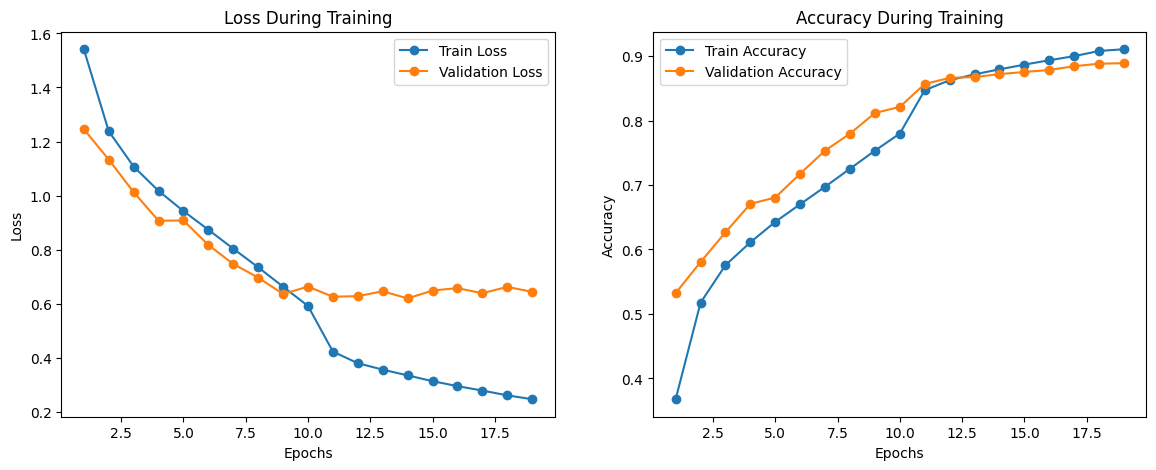

In [23]:
# Обучаем модель с ранней остановкой и сохранением лучших весов
model_save_path = 'emotion_recognition_model_V4++.pth'
model = train_model_with_metrics(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20, model_save_path=model_save_path, patience=5)
torch.save(model.state_dict(), model_save_path)

In [11]:
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms

# Загрузка обученной модели
model = EmotionRecognitionCNN(num_classes=6)
model.load_state_dict(torch.load('emotion_recognition_model_V4++.pth'))
model.eval()

# Загрузка классификатора Хаара для обнаружения лиц
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Преобразования для предобработки изображения
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Используем три канала
])

# Метки эмоций
emotions = ['Angry', 'Fearful', 'Sad', 'Happy', 'Surprised', 'Disgt']

# Запуск камеры
cap = cv2.VideoCapture(0)

while True:
    # Захват изображения с камеры
    ret, frame = cap.read()
    if not ret:
        break

    # Обнаружение лиц на изображении
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Извлечение лица
        face = frame[y:y + h, x:x + w]

        # Преобразование для модели
        face_img = transform(face).unsqueeze(0)  # Добавляем размер батча

        # Предсказание эмоции
        with torch.no_grad():
            output = model(face_img)
            emotion_prediction = F.softmax(output, dim=1)
            emotion_label = torch.argmax(emotion_prediction).item()

        # Метка предсказанной эмоции
        emotion_text = emotions[emotion_label]

        # Отображение предсказанной эмоции на изображении
        cv2.putText(frame, emotion_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Показ изображения
    cv2.imshow('Emotion Recognition', frame)

    # Прерывание по нажатию клавиши 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение камеры и закрытие окон
cap.release()
cv2.destroyAllWindows()



C:\Users\Omen\AppData\Local\Temp\ipykernel_14568\365247088.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('emotion_recognition_model_V4

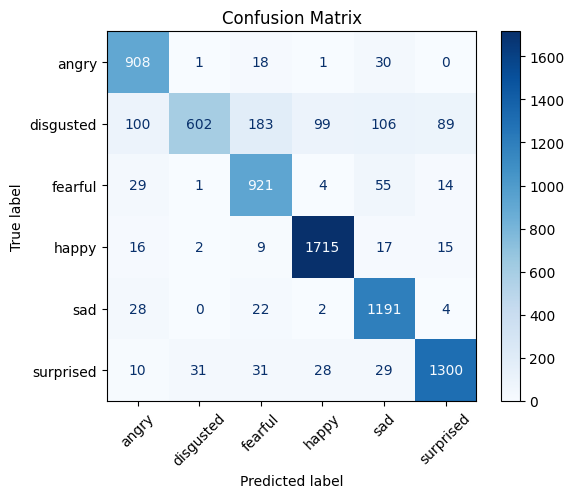

Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.95      0.89       958
   disgusted       0.95      0.51      0.66      1179
     fearful       0.78      0.90      0.83      1024
       happy       0.93      0.97      0.95      1774
         sad       0.83      0.96      0.89      1247
   surprised       0.91      0.91      0.91      1429

    accuracy                           0.87      7611
   macro avg       0.87      0.86      0.86      7611
weighted avg       0.88      0.87      0.86      7611



In [27]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model, dataloader, class_names, device):
    # Перенос модели на устройство
    model = model.to(device)
    model.eval()  # Переключаем модель в режим оценки
    all_preds = []
    all_labels = []

    # Сбор предсказаний и истинных меток
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Вычисляем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)

    # Отображаем матрицу ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    # Выводим отчет классификации
    print("Classification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)

evaluate(model, val_loader, class_names, device)
